# Transfer Learning using a CNN

Using the bird species classification dataset from kaggle: 
https://www.kaggle.com/gpiosenka/100-bird-species
 

#### Steps: 

1) Organisation: Download labelled images and divide into training and validation folders

2) Data pipeline: Reading data, preprocessing, grouping multiple images into batches
   
3) Data augmentation: Small changes like rotation, zooming etc. to increase variation in training data

4) Model definition

5) Training & testing

6) Save the model for a potential application 

In [20]:
# Import packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D,Conv2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Configurations
# We treat this problem as a multiclass problem, i.e. "cats vs dogs" (Number of classes 2)
TRAIN_DATA_DIR = 'data_bird_excerpt/train/'
VALIDATION_DATA_DIR = 'data_bird_excerpt/valid/'
NUM_CLASSES = 10
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

In [3]:
len(os.listdir(TRAIN_DATA_DIR))
# help(os.listdir())

10

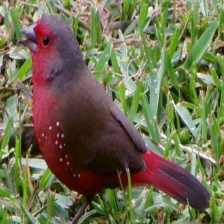

In [4]:
# Displaying images
img_path = 'data_bird_excerpt/train/AFRICAN FIREFINCH/001.jpg'
img = image.load_img(img_path, target_size=(224, 224)) 
img

In [5]:
# Shape of the image 
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
expanded_img_array
expanded_img_array.shape

(1, 224, 224, 3)

### Image Classification

- Input data are understood by DL algorithms as **tensors** (multidimensional array or list)

- Image data: 
    
    - Input batch of images 

    - 4D tensor:

<img src="Pictures/4_axis_tensor.png" style="width: 15%"/>


*https://www.tensorflow.org/guide/tensor*

- Images: 2 dimensions define Pixel values, 3rd RGB values, 4th number of images per batch

- In our case: $224*224*3*32$

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generates batches of image data with real-time data augmentation
# Loops over the data in batches
# ImageDataGenerator is a function provided by keras for augmenting the data while they are loaded
# preprocess_input: scale pixel values (0-255) of rgb channels to 0-1

In [7]:
# Images are combined into batches, training single images is inefficient
# Shuffling to introduce more randomness
# Seed for reproducibility
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 1272 images belonging to 10 classes.
Found 302 images belonging to 10 classes.


In [ ]:
# train_generator.class_indices

In [ ]:
# Simple ANN
ann_model = Sequential()
ann_model.add(Flatten(input_shape = (224,224,3))) # transform tensors to single array (i.e. to 1D)
ann_model.add(Dense(300, activation = 'relu'))
ann_model.add(Dense(100, activation = 'relu'))
ann_model.add(Dense(NUM_CLASSES, activation = 'sigmoid'))

# Configure and train the model
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['acc'])

ann_model.fit(
    train_generator, 
    epochs = 5, # epoch -> one full training step (network goes over entire dataset)
    validation_data=validation_generator, 
   ) 
# model.fit(x_train.values,y_train.values, validation_data=
# (x_val,y_val),epochs=10,batch_size=64)

Task: 
- Create and fit a simple CNN with:
    - Convolutional layer, MaxPooling2D, Convolutional Layer, MaxPooling2D, Flatten, 2 Dense layers
    - Use Relu as activation function, a 3*3 Kernel, 32 filters for the first convolutional layer, and 64 kernels for the second convolutional layer  

In [8]:
# Transfer Learning Model definition
# include_top = FALSE: Throw away last few specific layers (fully connected layers)
def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False # freeze the layers
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) # instantiate a Keras tensor
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model) # downsizing 
    custom_model = Dense(64, activation = 'relu')(custom_model)
    custom_model = Dropout(0.2)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

    # softmax normalises probabilities 
    # Example for two classes:
    # sigmoid: 0.5, 0.6.
    # softmax: 0.5 / (0.5 + 0.6), 0.6/ (0.5 + 0.6) 

In [90]:
model = model_maker()
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 3,295,114
Trainable params: 66,250
Non-trainable params: 3,228,864
_______________________________________

In [ ]:
# Information on MobileNet and its arguments:
# https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/README.md
# Paper: https://arxiv.org/pdf/1704.04861.pdf

# Example code to check the layers in MobildeNet() and how many of them are trainable:
base_model_test = MobileNet(include_top=True, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))
# all layers
for i, layer in enumerate(base_model_test.layers):
   print(i, layer.name)

# trainable
# for i,layer in enumerate(base_model_test.layers[:]):
#   print(i,layer.name,layer.trainable)
# Use ':' (slice) to change the number of trainable layers 
# e.g. for layer in base_model_test.layers[:5]:
#   layer.trainable=False

In [ ]:
# Model training 
# loss - categorical crossentropy: for feedback to the model
# metric - for reporting 
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001), 
              metrics=['acc'])
model.fit(
    train_generator, 
    epochs = 5,
    validation_data=validation_generator, 
   ) 

## Questions 

- Why there are 40 steps during each epoch?
- Can you spot any potential problems with the data?

In [ ]:
# Save model architecture, weights & training configuration
# see also: https://www.tensorflow.org/tutorials/keras/save_and_load
model.save('model_bird10')

In [84]:
# Testing the model on a sample image
# Load sample picture and check how the model performs
# img_path = 'data_bird_excerpt/images to test/14.jpg'
# img_path = 'data_bird_excerpt/images to test/sample_dog.jpeg'
img_path = 'data_bird_excerpt/images to test/european_greenfinch.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255.  # Preprocess the image
prediction = model.predict(preprocessed_img)
print(prediction.round(3))
print(validation_generator.class_indices)

[[0.    0.544 0.004 0.015 0.004 0.018 0.009 0.076 0.013 0.316]]
{'AFRICAN CROWNED CRANE': 0, 'AFRICAN FIREFINCH': 1, 'ALBATROSS': 2, 'ALEXANDRINE PARAKEET': 3, 'AMERICAN AVOCET': 4, 'AMERICAN BITTERN': 5, 'AMERICAN COOT': 6, 'AMERICAN GOLDFINCH': 7, 'AMERICAN KESTREL': 8, 'AMERICAN PIPIT': 9}


## Analyzing the results

### Important questions to ask: 
1. Which images is the model most confident about?

2. Which least confident?

3. Which images have incorrect predictions despite of having highly confident predictions from the model? 

## What to do to improve model accuracy?

- Acquire more training data

- Revise training data (wrong labels, images that show not the desired categories, items covering parts of the classified animals)

- Reasons for mispredictions: 
    - Too low or too high illumination
    - Size 
    - Difficult-to-distinguish backgrounds 

- Improve hyperparameters of the deep learning model 